In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


In [5]:
# pfcn_small.npz에서 train_images, test_images, train_mattes, test_mattes를 np array로 로드하세요.
data = np.load('pfcn_small.npz')
list(data)

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [13]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

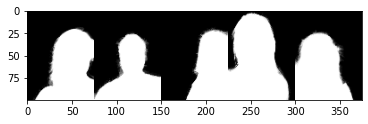

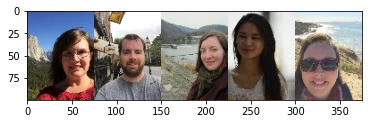

In [14]:
plt.imshow(np.hstack(train_mattes[:5]),cmap='gray')
plt.show()
    
plt.imshow(np.hstack(train_images[:5]))
plt.show()

In [15]:
print(np.shape(train_mattes))
print(np.shape(train_images))

print(np.shape(test_mattes))
print(np.shape(test_images))

(1700, 100, 75)
(1700, 100, 75, 3)
(300, 100, 75)
(300, 100, 75, 3)


In [16]:

print(train_images.max(), train_images.min())
print(test_images.max(), test_images.min())

1.0 0.0
1.0 0.0


In [21]:
train_mattes =np.expand_dims(train_mattes,axis=3)
test_mattes=np.expand_dims(test_mattes,axis=3)
train_mattes.shape, test_mattes.shape

((1700, 100, 75, 1), (300, 100, 75, 1))

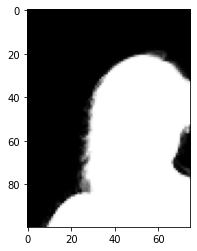

In [25]:
plt.imshow(train_mattes[0].reshape(100,75),cmap='gray')

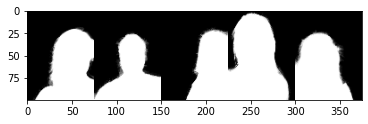

In [26]:
plt.imshow(train_mattes[:5].transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray")
plt.show()

## AE 모델링

In [27]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
  inputs = Input((100, 75, 3))
  x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
  x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
  x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
  x = Flatten()(x)
  latent = Dense(10)(x)

  x = Dense((13 * 10 * 128))(latent)
  x = Reshape((13, 10, 128))(x)

  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)
  
  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)

  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)

  x = Conv2D(1, (1,1), (1,1), activation='sigmoid')(x)


  model = Model(inputs, x)
  return model

In [28]:
model = ae_like()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 16640)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                166410    
_________________________________________________________________
dense_1 (Dense)              (None, 16640)             183040

In [29]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [30]:
hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 18s 25ms/step - loss: 0.1424 - accuracy: 0.7439 - val_loss: 0.1269 - val_accuracy: 0.7621
Epoch 2/25
54/54 [==============================] - 1s 18ms/step - loss: 0.1257 - accuracy: 0.7630 - val_loss: 0.1210 - val_accuracy: 0.7640
Epoch 3/25
54/54 [==============================] - 1s 17ms/step - loss: 0.1153 - accuracy: 0.7757 - val_loss: 0.0971 - val_accuracy: 0.8017
Epoch 4/25
54/54 [==============================] - 1s 17ms/step - loss: 0.0905 - accuracy: 0.8110 - val_loss: 0.0834 - val_accuracy: 0.8176
Epoch 5/25
54/54 [==============================] - 1s 17ms/step - loss: 0.0809 - accuracy: 0.8237 - val_loss: 0.0820 - val_accuracy: 0.8193
Epoch 6/25
54/54 [==============================] - 1s 17ms/step - loss: 0.0728 - accuracy: 0.8348 - val_loss: 0.0732 - val_accuracy: 0.8317
Epoch 7/25
54/54 [==============================] - 1s 19ms/step - loss: 0.0641 - accuracy: 0.8463 - val_loss: 0.0754 - val_accuracy: 0.8288
Epoch 8/25
5

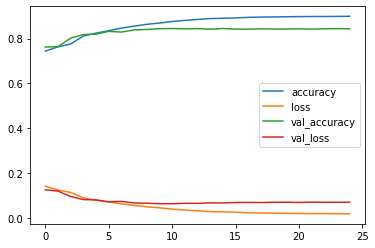

In [31]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "uppder left")
plt.show()

In [32]:

res = model.predict( test_images[0:1] )

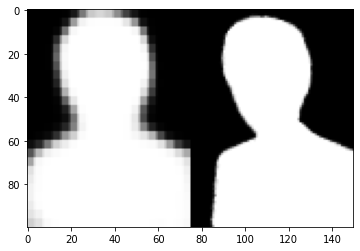

In [33]:
plt.imshow( np.concatenate([res[0], test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") 
plt.show()

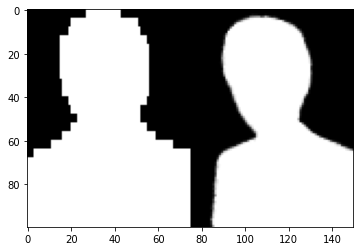

In [34]:
# res를 0.5기준으로 0,1의 값으로 이원화 시켜서 경계영역을 좀더 명확하게 함
plt.imshow( np.concatenate([(res[0] > 0.5).astype(np.float64), test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") 
plt.show()

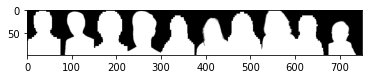

In [35]:

five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow( np.concatenate([five , test_mattes[:5]], axis=2).transpose((1, 0, 2, 3)).reshape(100, -1) , cmap="gray") 
plt.show()


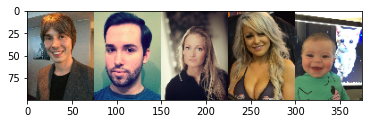

In [36]:
plt.imshow(test_images[:5].transpose((1, 0, 2, 3)).reshape((100, -1, 3))) 
plt.show()

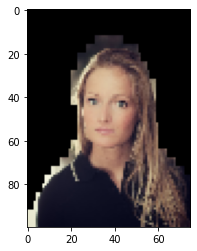

In [37]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지움

plt.imshow ( five[2].reshape((100, 75, 1)) * test_images[2]  )
plt.show()

##  U-net 모델링

In [38]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
  x = Conv2D(channel, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(channel, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def unet_like():
  inputs = Input((100, 75, 3))

  c1 = conv2d_block(inputs, 16)
  p1 = MaxPool2D((2,2))(c1)
  p1 = Dropout(0.1)(p1)

  c2 = conv2d_block(p1, 32)
  p2 = MaxPool2D((2,2))(c2)
  p2 = Dropout(0.1)(p2)

  c3 = conv2d_block(p2, 64)
  p3 = MaxPool2D((2,2))(c3)
  p3 = Dropout(0.1)(p3)

  c4 = conv2d_block(p3, 128)
  p4 = MaxPool2D((2,2))(c4)
  p4 = Dropout(0.1)(p4)

  c5 = conv2d_block(p4, 256)

  u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(0.1)(u6)
  c6 = conv2d_block(u6, 128)

  u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(0.1)(u7)
  c7 = conv2d_block(u7, 64)

  u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(0.1)(u8)
  c8 = conv2d_block(u8, 32)

  u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(0.1)(u9)
  c9 = conv2d_block(u9, 16)

  outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

  model = Model(inputs, outputs)
  return model

In [39]:
# unet_like() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_like()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 75, 16)  448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [ ]:

hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 6s 62ms/step - loss: 0.1500 - accuracy: 0.7122 - val_loss: 0.1838 - val_accuracy: 0.6844
Epoch 2/25
54/54 [==============================] - 2s 46ms/step - loss: 0.0591 - accuracy: 0.8518 - val_loss: 0.3090 - val_accuracy: 0.5756
Epoch 3/25
54/54 [==============================] - 3s 47ms/step - loss: 0.0483 - accuracy: 0.8650 - val_loss: 0.1278 - val_accuracy: 0.7630
Epoch 4/25
54/54 [==============================] - 2s 46ms/step - loss: 0.0391 - accuracy: 0.8743 - val_loss: 0.1301 - val_accuracy: 0.7566
Epoch 5/25
54/54 [==============================] - 2s 46ms/step - loss: 0.0325 - accuracy: 0.8807 - val_loss: 0.0949 - val_accuracy: 0.8106
Epoch 6/25
54/54 [==============================] - 3s 47ms/step - loss: 0.0310 - accuracy: 0.8827 - val_loss: 0.0725 - val_accuracy: 0.8286
Epoch 7/25
54/54 [==============================] - 2s 46ms/step - loss: 0.0296 - accuracy: 0.8836 - val_loss: 0.0631 - val_accuracy: 0.8481
Epoch 8/25
54

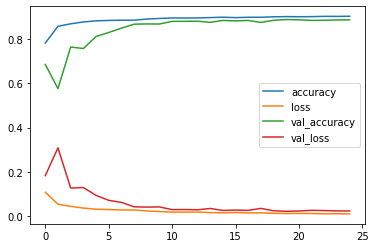

In [ ]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "uppder left")
plt.show()

In [ ]:
loss, acc = model.evaluate(test_images, test_mattes, verbose=1)
print(loss, acc)

In [ ]:

res = model.predict( test_images[2:3] )

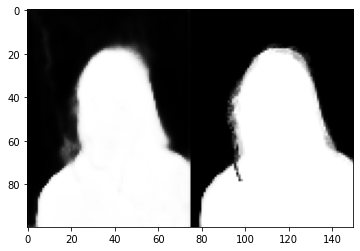

In [ ]:
imgs = np.concatenate([res.reshape((100, 75, 1)), test_mattes[2]]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs, cmap="gray")
plt.show()

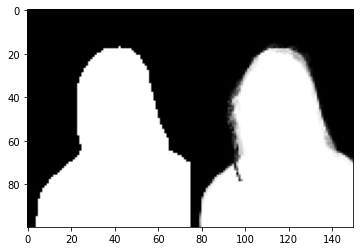

In [ ]:

imgs = np.concatenate([(res > 0.5).astype(np.float64).reshape((100, 75, 1)), test_mattes[2] ]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs, cmap="gray")
plt.show()


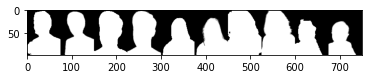

In [ ]:

five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow( np.concatenate([five , test_mattes[:5]], axis=2).transpose((1, 0, 2, 3)).reshape(100, -1) , cmap="gray") 
plt.show()

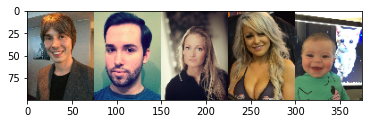

In [ ]:
plt.imshow(test_images[:5].transpose((1,0, 2, 3)).reshape((100, -1, 3)))
plt.show()

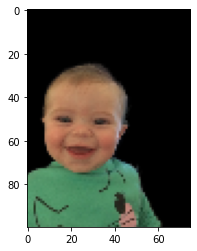

In [ ]:
# 아래와 같이 나오는게 목적임(제공되는 배경제거 자료와 매칭한 자료임)
plt.imshow(test_images[4] * test_mattes[4].reshape((100, 75 ,1)))
plt.show()

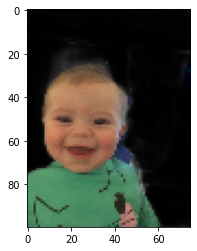

In [ ]:
# 딥러닝 모델임
plt.imshow(test_images[4] * model.predict(test_images[4:5]).reshape((100, 75 ,1)))
plt.show()

In [ ]:
# 모델을 저장하는 코드를 작성하세요.
model.save("./배경제거.h5")